In [1]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
from HINTS import *
from HINTS_fn import *


In [2]:
# NB the proposed state must not share memory with the original state (because we hash when we cache)
def proposal1(state, index):
    return(state + 0.1 * randn(state.shape[0]), 0.0) # new state, optional evaluation at new state, correction for asymmetry  



In [3]:
# test the  Test function
xs = np.arange(-2.0, 2.0, 0.001)
shuffle(xs) # so noise is random

exs = np.expand_dims(xs, axis=1)
print(exs.shape)

e = TestFn(proposal1, xs.size)



(4000, 1)


In [4]:

%time ys = [e.evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))
%time ys = [e.evaluate(x, i) for i, x in enumerate(exs)]
#%time ys = [e.cached_evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))
#%time ys = [e.user_evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))

# caching has a big overhead!!


CPU times: user 113 ms, sys: 16 ms, total: 129 ms
Wall time: 128 ms
CPU times: user 3.45 ms, sys: 0 ns, total: 3.45 ms
Wall time: 3.45 ms


In [33]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults
#HINTS payoff comes for large num scenarios > 1000
# checked regular MCMC is accurate (1 level, lbf = 6)
if False:
    args.levels = 5
    log_branch_factor = 2
    N_0 = 1
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    iterations = 5000
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 1024
    args.design = np.array([NUM_SCENARIOS])
    iterations = 42094# need to match actual evaluations

print(NUM_SCENARIOS)

# design now has levels + 1 entries

# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = True # effectively selects a different temperature structure when False (= average or expectation)

args.T = 1.0 #top level
args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)

print(args.__dict__)

1024
{'levels': 0, 'design': array([1024]), 'additive': True, 'T': 1.0, 'dT': 0.0}


In [34]:

g = TestFn(proposal1, NUM_SCENARIOS, args.additive)
hmc = HINTS(args, g)
state  = g.sample_initial_state()
print(state)

nsd = 4.0 # for diagnostics only
bins = 64

histogram = np.zeros([bins], dtype = float)

#%timeit hmc.shuffle() # negligible
#%timeit hmc.hints(state,  levels, index = 0, T = 1.0, dbg = False) # e.g. dbg = (t==0)




RESET
0
[1024]
1024
[1.]
[1.64879722]


In [35]:
# FAR FASTER WITHOUT CACHING FOR SIMPLE TEST TASKS
# SO IF WE CACHE, SHOULD BE BIG CHUNKS. OR WE AVOID MEMOIZING
# e.g. JUST KEEP LUT PER STATE (i.e. at each level)

#cache.clear()
#print(cache.stats(enable=True, reset = True))
for t in range(iterations):
    hmc.shuffle()
    state, correction = hmc.hints(state, args.levels) # e.g. dbg = (t==0)
    # diagnostic histogram
    if (abs(state[0]) < nsd): # ignoring samples outside diagnostic range
        j = int((state[0] + nsd) * bins/(2.0 * nsd))
        histogram[j] += 1.0
    # show progress
    if ((t%500)==499):
        print(t+1, hmc.acceptances, hmc.rejections)
        #print(cache.stats(enable=True, reset = True))


500 [477] [23]
1000 [961] [39]
1500 [1452] [48]
2000 [1935] [65]
2500 [2424] [76]
3000 [2910] [90]
3500 [3397] [103]
4000 [3892] [108]
4500 [4368] [132]
5000 [4857] [143]
5500 [5347] [153]
6000 [5839] [161]
6500 [6317] [183]
7000 [6804] [196]
7500 [7284] [216]
8000 [7770] [230]
8500 [8263] [237]
9000 [8750] [250]
9500 [9240] [260]
10000 [9718] [282]
10500 [10191] [309]
11000 [10682] [318]
11500 [11153] [347]
12000 [11626] [374]
12500 [12119] [381]
13000 [12601] [399]
13500 [13092] [408]
14000 [13576] [424]
14500 [14053] [447]
15000 [14539] [461]
15500 [15029] [471]
16000 [15518] [482]
16500 [16007] [493]
17000 [16490] [510]
17500 [16972] [528]
18000 [17463] [537]
18500 [17941] [559]
19000 [18388] [612]
19500 [18877] [623]
20000 [19362] [638]
20500 [19837] [663]
21000 [20324] [676]
21500 [20794] [706]
22000 [21275] [725]
22500 [21765] [735]
23000 [22250] [750]
23500 [22735] [765]
24000 [23223] [777]
24500 [23711] [789]
25000 [24205] [795]
25500 [24687] [813]
26000 [25171] [829]
26500 [2

In [38]:
print(histogram)
print(hmc.acceptances)
print(hmc.rejections)
print(hmc.acceptances / (hmc.acceptances + hmc.rejections))

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 2.000e+01
 5.800e+01 4.600e+01 4.800e+01 5.500e+01 6.400e+01 8.500e+01 1.430e+02
 1.550e+02 2.100e+02 3.040e+02 3.570e+02 5.590e+02 7.280e+02 8.430e+02
 9.810e+02 1.045e+03 1.056e+03 1.228e+03 1.505e+03 1.648e+03 1.733e+03
 1.937e+03 2.012e+03 2.106e+03 2.272e+03 2.336e+03 2.316e+03 2.480e+03
 2.178e+03 1.975e+03 1.739e+03 1.360e+03 1.106e+03 9.780e+02 8.190e+02
 7.260e+02 5.990e+02 5.320e+02 4.560e+02 4.040e+02 3.420e+02 1.970e+02
 1.180e+02 8.600e+01 5.200e+01 4.600e+01 3.500e+01 1.000e+01 4.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00]
[40799]
[1295]
[0.96923552]


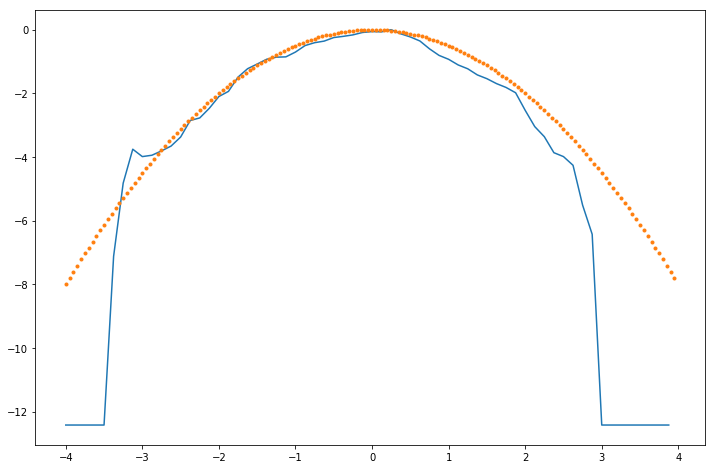

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt # just for testing

#plt.plot(histogram)
fig = plt.figure(figsize=[12,8])
ax1 = plt.gca()
xs1 = np.arange(bins, dtype = float) * (2.0 * nsd)/bins - nsd 

logprob = np.log(histogram + 0.01)

plt.plot(xs1, logprob - np.max(logprob))
xs = np.arange(-nsd, nsd, nsd/80.0)
shuffle(xs) # so noise is not correlated with term
exs = np.expand_dims(xs, axis=1)

#hxs = [HashableItem(np.array([x])) for x in xs]

# do not create a new test function here... use the same one
if args.additive:
    ys = [sum([g.evaluate(x, i) for i in range(NUM_SCENARIOS)]) for x in exs]
else:
    ys = [sum([g.evaluate(x, i)/NUM_SCENARIOS for i in range(NUM_SCENARIOS)]) for x in exs]

plt.plot(xs, ys,'.')


In [25]:
print('Calls: {:,}; '.format(g.total_counter) + 'Missed cache: {:,}; '.format(g.counter) + 'Miss rate: {}%'.format(int((100.0 * g.counter)/g.total_counter)))

Calls: 61,440,000; Missed cache: 43,104,413; Miss rate: 70%


In [32]:
#iterations = int(g.counter/NUM_SCENARIOS) # for MCMC
iterations = int(43104413/NUM_SCENARIOS) # for MCMC
iterations

42094

In [31]:
from line_profiler import LineProfiler

lp = LineProfiler()
lp.add_function(g.__call__)
lp.add_function(g.cached_evaluate)
lp_wrapper = lp(hmc.hints)
lp_wrapper(state, args.levels)
#lp_wrapper = lp(g.evaluate)
#lp_wrapper(np.array([0.123456789]), args.levels)
lp.print_stats()



Timer unit: 1e-06 s

Total time: 0.00012 s
File: /home/malcolm/dev/HINTS/HINTS.py
Function: hints at line 41

Line #      Hits         Time  Per Hit   % Time  Line Contents
    41                                               def hints(self, state, level, index = 0, always_accept = False): # main function, requires value of current as input
    42         1        120.0    120.0    100.0          if (level == 0): return(self.primitive_move(state, index)) # this is only separate so we can override
    43                                                   scenarios = self.scenarios(level, index)
    44                                                   correction = 0.0
    45                                                   current = state # we hold state at all levels in the hierarchy
    46                                                   for b in range(self.design[level]):
    47                                                       current, delta_correction = self.hints(current, leve

In [10]:
# TO DO 
# pytorch test function
# state is model
# proposal is grad descent + noise (Langevin or HMC style) on minibatch
# SEE TorchModelScratch